# Example of WDf usage with multi data segments and multi-processing

*author: Elena Cuoco*

**Cuoco et al., Wavelet-Based Classification of Transient Signals for Gravitational Wave Detectors
DO  - 10.23919/EUSIPCO.2018.8553393**


Please note that many packages, as graphic one or logging are not part of WDF docker, but you can install them locally or use your preferred ones

In [1]:
# import libraries
import time
import os
from pytsa.tsa import *
from pytsa.tsa import SeqView_double_t as SV
from wdf.config.Parameters import *
from wdf.processes.wdfUnitDSWorker import *
from wdf.processes.wdfUnitWorker import *
import logging
import coloredlogs
#select level of logging
coloredlogs.install(isatty=True)
 
logging.basicConfig(level=logging.DEBUG)



In [2]:
import requests

# Public sharing link
data_link = "https://www.dropbox.com/scl/fi/5353u1zwua9bcyhvg2c5k/test.gwf?rlkey=muqmpl94nlgmqyr7qej5sq4t6&st=bk6mtdd0&dl=1"
data_file = "test.gwf"

# Download file
response = requests.get(data_link, allow_redirects=True, stream=True)
if response.status_code == 200:
    with open(data_file, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
    print(f"File downloaded successfully as {data_file}")
else:
    print(f"Error: {response.status_code}, {response.text}")

File downloaded successfully as test.gwf


In [7]:
new_json_config_file = True    # set to True if you want to create new Configuration

if new_json_config_file==True:
    configuration = {
  "window":1024,
  "overlap":768,
  "threshold": 0.2,
  "file": "./test.gwf",
  "channel": "H1:GWOSC-4KHZ_R1_STRAIN",
  "run":"offLine",
  "len":10.0,
  "itf": "H",
  "gps":1167559608,
  "segments":[[1167559008,1167559408],[1167559408,1167560008],[1167560008,1167560308]],
  #"segments":[[1167559608,1167560008] ],      
  "outdir": "local_dir/",
  "dir":"local_dir/",
  "ID":"WDF_test",
  "ARorder": 1000,
  "learn": 200,
  "preWhite":2,
  "ResamplingFactor":2,
  "LowFrequencyCut":12,
  "FilterOrder":6,
  "nproc":4
}

    filejson = os.path.join(os.getcwd(),"inputWDF.json")
    file_json = open(filejson, "w+")
    json.dump(configuration, file_json)
    file_json.close()

logging.info("read parameters from JSON file")
par = Parameters()
 
filejson = "inputWDF.json"     
try:
    par.load(filejson)
except IOError:
    logging.error("Cannot find resource file " + filejson)
    quit()

par.print() 

2025-08-28 14:10:16 61b0fa9a1dbe root[80] INFO read parameters from JSON file


{   'ARorder': 1000,
    'FilterOrder': 6,
    'ID': 'WDF_test',
    'LowFrequencyCut': 12,
    'ResamplingFactor': 2,
    'channel': 'H1:GWOSC-4KHZ_R1_STRAIN',
    'dir': 'local_dir/',
    'file': './test.gwf',
    'gps': 1167559608,
    'itf': 'H',
    'learn': 200,
    'len': 10.0,
    'nproc': 4,
    'outdir': 'local_dir/',
    'overlap': 768,
    'preWhite': 2,
    'run': 'offLine',
    'segments': [   [1167559008, 1167559408],
                    [1167559408, 1167560008],
                    [1167560008, 1167560308]],
    'threshold': 0.2,
    'window': 1024}


It is important that you define correctly the parameters in the configuration files. WDf is a pipeline which performs a series of steps before producing triggers for transient signals in your data. Here it is the list of parameters you can fix in your configuration file. 

* ARorder = order of  AutoRegressive model for whitening
* ID = identification numer for your run
* ResamplingFactor = the ratio between the original sampling frequency and the downsampled one
* channel = the name of the channel in you .gwf o .ffl file you want to analyze
* dir = where to find the parameters
* file = file to be anlyzed
* gps = the starting time for for analysis (overwritten by values in segments)
* learn = the length in seconds of the data you will use to estimate AR parameters
* len = the time window in second of data loaded in you loop
* nproc = the number of processors you will use
* outdir = where you want to save the results
* overlap = overlapping number between 2 consecutives windows for WDF analysis
* prewhite = the number of iter to pre-heat the whitening procedure (leave as it is)
* run = additional tag for your data run
* segments = 1 or more segments defined as [start time, end time] where you will run WDF, usually 1 segment/processor
* threshold = the minimum value for WDF snr to identify a trigger
* window = the analyzing window in point for WDF. It should be a power of 2

**If you set the par.dir or par.outdir as relative path, we need to give the absolute path.**

In [8]:
import os
par.dir=os.getcwd()+'/'+par.dir
par.outdir=os.getcwd()+'/'+par.outdir

## Load information for sampling frequency

In [9]:
strInfo = FrameIChannel(par.file, par.channel, 1.0, par.gps)
Info = SV()
strInfo.GetData(Info)
par.sampling = int(1.0 / Info.GetSampling())
if par.ResamplingFactor!=None:
    par.resampling = int(par.sampling / par.ResamplingFactor)
    logging.info("sampling frequency= %s, resampled frequency= %s" %(par.sampling, par.resampling))
del Info, strInfo


2025-08-28 14:10:30 61b0fa9a1dbe root[80] INFO sampling frequency= 4096, resampled frequency= 2048


## Launch WDF runs

### The fullPrint option is important to save information about the WDF triggers
* fullPrint = 0 --> you save only the metaparameters for the triggers
* fullPrint = 1 --> you save the metaparameters and the wavelet coefficients for that trigger
* fullPrint = 2 --> you save the metaparameters and the reconstructed waveform for that trigger
* fullPring = 3 --> you save the metaparameters, the wavelet coefficients and the reconstructed waveform for that trigger in the 'window' time (window/sampling frequency)

In [10]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())
pool = mp.Pool(par.nproc) 

wdf=wdfUnitDSWorker(par,fullPrint=2)    
pool.map(wdf.segmentProcess, [segment for segment in par.segments])
pool.close()     
 

Number of processors:  4


2025-08-28 14:10:32 61b0fa9a1dbe root[151] INFO Analyzing segment: 1167559008-1167559408 for channel H1:GWOSC-4KHZ_R1_STRAIN downsampled at 2048Hz
2025-08-28 14:10:32 61b0fa9a1dbe root[151] INFO Start AR parameter estimation
2025-08-28 14:10:32 61b0fa9a1dbe root[152] INFO Analyzing segment: 1167559408-1167560008 for channel H1:GWOSC-4KHZ_R1_STRAIN downsampled at 2048Hz
2025-08-28 14:10:32 61b0fa9a1dbe root[154] INFO Analyzing segment: 1167560008-1167560308 for channel H1:GWOSC-4KHZ_R1_STRAIN downsampled at 2048Hz
2025-08-28 14:10:32 61b0fa9a1dbe root[152] INFO Start AR parameter estimation
2025-08-28 14:10:32 61b0fa9a1dbe root[154] INFO Start AR parameter estimation
2025-08-28 14:11:45 61b0fa9a1dbe root[154] INFO Estimated sigma= 4.0062637269449494e-22
2025-08-28 14:11:48 61b0fa9a1dbe root[152] INFO Estimated sigma= 4.0675451444151897e-22
2025-08-28 14:11:48 61b0fa9a1dbe root[151] INFO Estimated sigma= 4.0023147527036696e-22
2025-08-28 14:11:57 61b0fa9a1dbe root[154] INFO Starting dete

In the output dir with 'run' tag you will find the estimated AR coefficients, and a .csv files containing the trigger lists

## Let's have a look at the results

In [13]:
import pandas as pd 
 
import glob

dirName = par.outdir # use your path
all_files = glob.glob(os.path.join(dirName, "**","*.csv"), recursive=True)     # advisable to use os.path.join as this makes concatenation OS independent
df_from_each_file = (pd.read_csv(f) for f in all_files)
triggers  = pd.concat(df_from_each_file, ignore_index=True) 

In [14]:
triggers.shape

(5810, 1035)

In [15]:
import matplotlib.pylab as plt
pd.set_option('display.max_rows', 999)
pd.set_option('max_colwidth',100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import numpy as np
 
%matplotlib inline
# Alternatives include bmh, fivethirtyeight, ggplot,
# dark_background, seaborn-deep, etc
plt.style.use('ggplot') 
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['figure.figsize'] = (14, 10)
 
colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)
plt.figure(0)
print (triggers.shape)
  
triggers.head(10)

 


ModuleNotFoundError: No module named 'matplotlib'

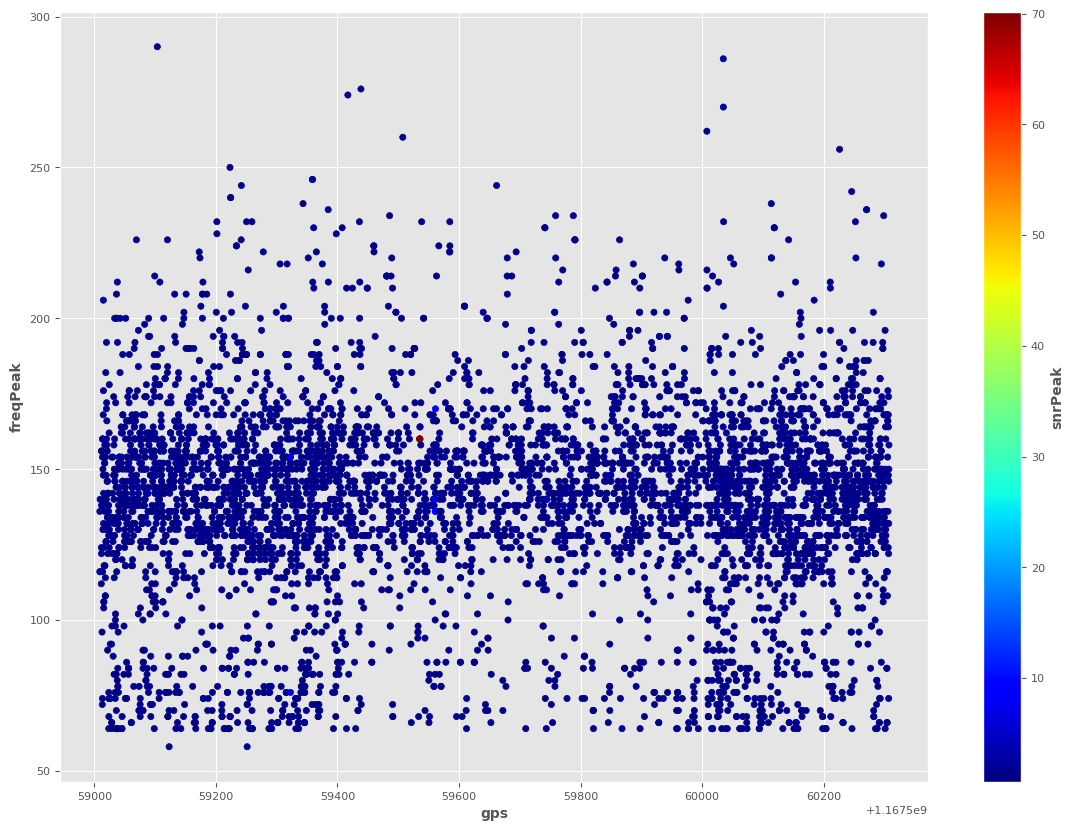

In [9]:
ax2 = triggers.plot.scatter(x='gps',
                      y='freqPeak',
                      c='snrPeak',
                      colormap='jet')


In [10]:
df=triggers[triggers['snrPeak']>4]

(12, 1035)


/tmp/ipykernel_4076457/2239143324.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['5','10', '20', '30', '40', '50', '60','>60'])


Text(0.5, 1.0, 'Frequency versus time for triggers')

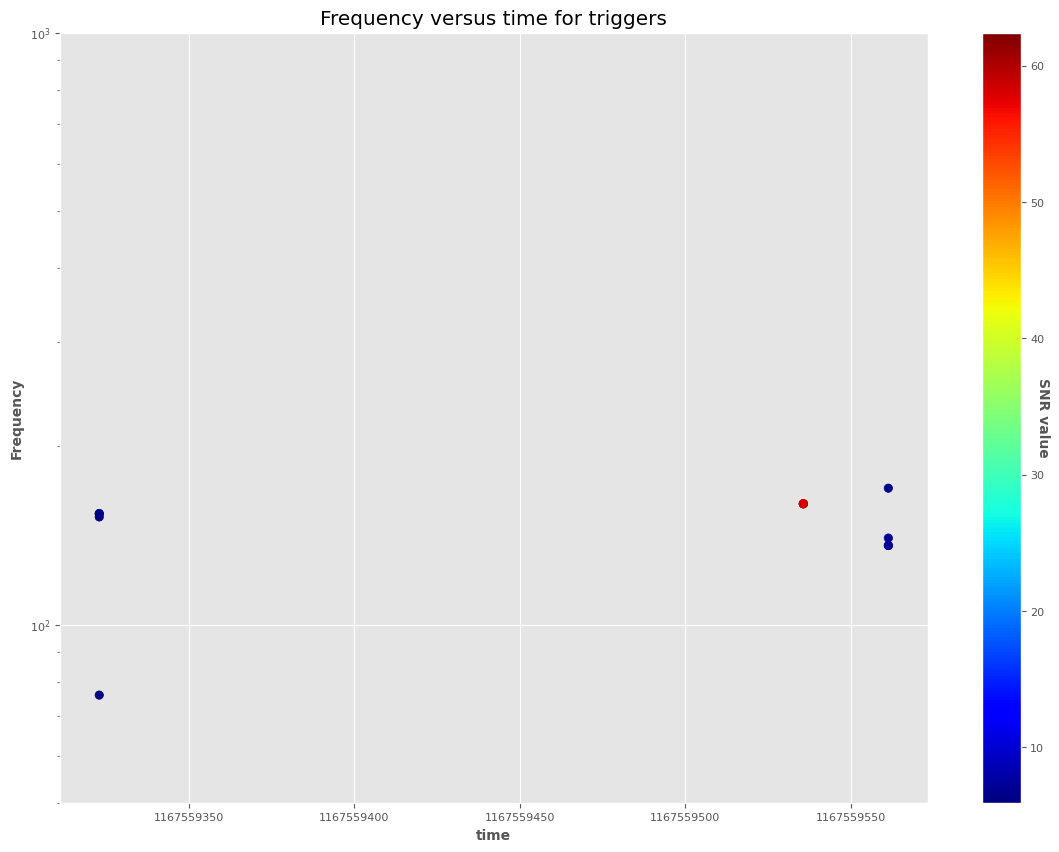

In [11]:
plt.figure(0)
print (df.shape)
 
from matplotlib.ticker import FormatStrFormatter

sc = plt.scatter(df.gpsPeak,
                 df.freqPeak,c=df.EnWDF, cmap='jet')
 
# legend
cbar = plt.colorbar(sc)
cbar.ax.set_yticklabels(['5','10', '20', '30', '40', '50', '60','>60'])
cbar.set_label('SNR value', rotation=270)

plt.ylim(50, 1000)
plt.yscale('log') 
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
plt.gca().get_xaxis().get_major_formatter().set_scientific(False)
plt.xlabel("time")
plt.ylabel("Frequency")
plt.title("Frequency versus time for triggers")

In [12]:
df=triggers.sort_values('EnWDF', ascending=False)

In [13]:
df.head(10)    

,gps,gpsPeak,duration,EnWDF,snrMean,snrPeak,freqMin,freqMean,freqMax,freqPeak,...,rw1014,rw1015,rw1016,rw1017,rw1018,rw1019,rw1020,rw1021,rw1022,rw1023
4255,1167559535.375,1167559535.639,0.019,6.242,4.661,70.169,76.000,152.577,262.000,160.000,...,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000
4254,1167559535.250,1167559535.639,0.019,6.219,4.659,70.154,74.000,146.962,260.000,160.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4256,1167559535.500,1167559535.639,0.019,6.170,4.658,70.118,76.000,150.308,262.000,160.000,...,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000
4257,1167559535.625,1167559535.639,0.019,5.798,4.624,69.640,80.000,152.192,264.000,160.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000
4341,1167559560.875,1167559561.331,0.276,0.706,0.529,8.874,58.000,156.846,276.000,140.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000
4343,1167559561.125,1167559561.331,0.107,0.687,0.517,8.830,58.000,152.923,278.000,136.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000
1673,1167559322.500,1167559322.928,0.497,0.685,0.474,7.734,54.000,146.731,240.000,154.000,...,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000
4344,1167559561.250,1167559561.331,0.018,0.679,0.506,8.830,68.000,149.731,222.000,170.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000
4342,1167559561.000,1167559561.331,0.276,0.675,0.522,8.674,58.000,155.308,276.000,136.000,...,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000
1674,1167559322.625,1167559322.928,0.411,0.648,0.462,7.642,62.000,150.154,240.000,154.000,...,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000


In [14]:
wav=np.array(triggers.loc[triggers['EnWDF'].idxmax()][11:].values)
 

([<matplotlib.lines.Line2D at 0x7fc742d42310>],)

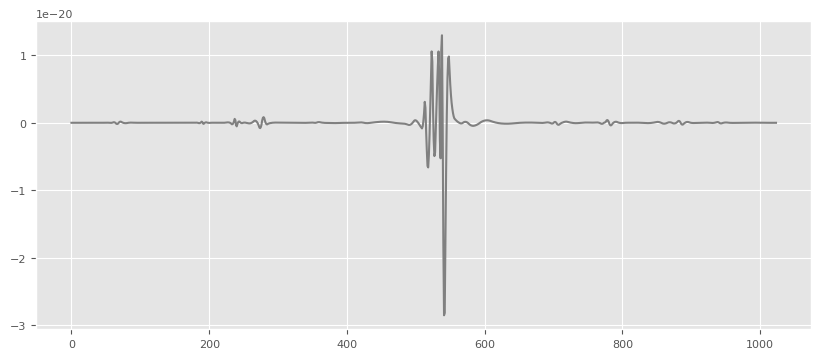

In [15]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['agg.path.chunksize']=10000
%matplotlib inline 

plt.figure(figsize=(10,4)),
plt.plot(wav,'gray',label='h'),
 

([<matplotlib.lines.Line2D at 0x7fc742d950d0>],)

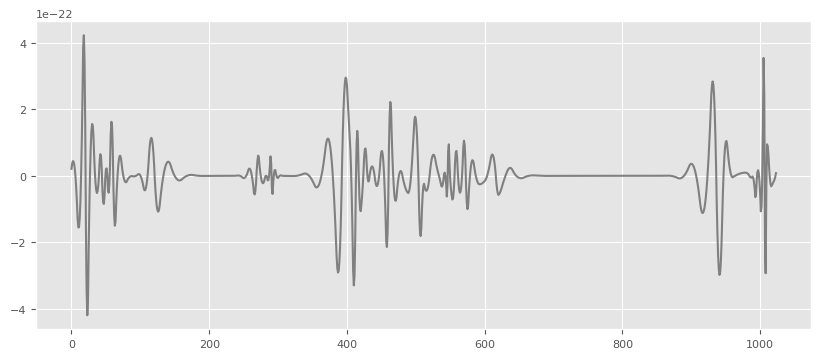

In [16]:
wav=np.array(triggers.loc[11][11:].values)

plt.figure(figsize=(10,4)),
plt.plot(wav,'gray',label='h'),